<a href="https://colab.research.google.com/github/tjtyler/MachLearn_DecisionTree_ID3/blob/main/lab_3_decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Tree Lab

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import math 
import pdb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. (40%) Correctly implement the ID3 decision tree algorithm, including the ability to handle unknown attributes (You do not need to handle real valued attributes).  
### Code Requirements/Notes:
- Use standard information gain as your basic attribute evaluation metric.  (Note that normal ID3 would usually augment information gain with gain ratio or some other mechanism to penalize statistically insignificant attribute splits.) 
- You are welcome to create other classes and/or functions in addition to the ones provided below. (e.g. If you build out a tree structure, you might create a node class).
- It is a good idea to use a simple data set (like the lenses data or the pizza homework), which you can check by hand, to test your algorithm to make sure that it is working correctly. 

In [ ]:
class Node():
  def __init__(self,X,y,par_node=None, par_entrop=None, node_feat=None, leaf=False,split_indx=None, depth=0):
    self.X=X
    self.y=y
    self.entropy = self.entropy()
    self.parent_entropy = par_entrop
    self.parent_node = par_node
    self.children = None
    self.leaf = leaf
    self.depth = depth
    self.split_indx = split_indx #index of attrib to split on
    self.maj_class = None
    self.info_gained = None
    self.counts = self.calc_counts()
    self.node_feat = node_feat

  def entropy(self):
    quants = np.bincount(self.y.flatten())
    props = quants / np.sum(quants)
    entrop = 0
    for i in range(len(quants)):
      if props[i] != 0:
        entrop += -props[i]*math.log2(props[i])
    return entrop
  
  def calc_counts(self):
    xy_concat = np.concatenate((self.X, self.y.reshape(self.y.shape[0],1)), axis=1)
    cnts = []
    for i in range(xy_concat.shape[1]):
      cnts.append(np.bincount(xy_concat[:,i]).shape[0])
    return cnts


  def set_split_indx(self, split_indx):
    self.split_indx = split_indx
  
  def set_children(self, children):
    self.children = children

  def set_is_leaf(self,leaf):
    self.leaf = leaf
  
  def set_majority_cls(self, cls):
    self.maj_class = cls

  def set_info_gained(self,info_gained):
    self.info_gained = info_gained


In [ ]:
class DTClassifier(BaseEstimator,ClassifierMixin):

    def __init__(self):
        """ Initialize class with chosen hyperparameters.
        Args:
        Optional Args (Args we think will make your life easier):
            counts: A list of Ints that tell you how many types of each feature there are
        Example:
            DT  = DTClassifier()
            or
            DT = DTClassifier(count = [2,3,2,2])
            Dataset = 
            [[0,1,0,0],
            [1,2,1,1],
            [0,1,1,0],
            [1,2,0,1],
            [0,0,1,1]]

        """
        self.information_gained = []

    def fit(self, X, y):
        """ Fit the data; Make the Decision tree

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 1D numpy array with the training targets

        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)

        """
        # self.root = Node()
        # self.make_tree(self.root)
        self.root = Node(X=X,y=y,par_node=None, par_entrop=None, node_feat=None, leaf=False,split_indx=None,depth=0)
        self.make_tree(self.root)
        return self

    def make_tree(self,node):
      # IF BASE CASE
      # Base Case:
        # if it's supposed to be a leaf node, make it a leaf node and set its majority class
        # return
      if node.entropy == 0 and node.y.shape[0] !=0:
        node.set_is_leaf(True)
        cls = node.y[0]
        node.set_majority_cls(cls)
        node.set_info_gained(node.entropy)
        return

      # IF THE NODE IS NOT A LEAF NODE THEN: 
        # DO STUFF
        # Finding the best feature to split on
        # Make the split (create all the children nodes) 
      else:
        # FIND THE BEST FEATURE TO SPLIT ON
        pos_children = [] # possible features to become children [[]]
        avrg_children_ents = []

        for ft_indx in range(node.X.shape[1]): # these are the columns of the X array
          feat_cnts = np.bincount(node.X[:,ft_indx]) # this is a 1D np array that contains at each indx of the np.arr how many numbers are in in the column
          feat_props = feat_cnts / np.sum(feat_cnts) # this is the proportions of each attribute of feat[ft_indx]
          feat_children = [] # this will be a list of the children nodes of feat[ft_indx]
          avrg_ent = 0 # average entropy of a feature's children
          # LOOP OVER ALL OF THE ATTRIBUTES OF THE FEATURE (if counts = [3,4,3] and the feature is 0, then we loop from 0 to 2)
          for unq_val in range(node.counts[ft_indx]):
            xy_concat = np.concatenate((node.X, node.y.reshape(node.y.shape[0],1)), axis=1) # concatenate the X and y from the node that was passed in
            Xy_child = xy_concat[xy_concat[:,ft_indx] == unq_val] # create the sub array for this child where the attribs of the feat = unq_val
            child_X = Xy_child[:,:-1] # split Xy_child to get the X for the child
            child_y = Xy_child[:,-1] # split Xy_child to get teh y for the child
            child = Node(X=child_X,y=child_y,par_node=node, par_entrop=node.parent_entropy, node_feat=unq_val, depth=node.depth+1) # create the child node and increment its depth
            avrg_ent += child.entropy*feat_props[unq_val] # add this child's entropy to the avrg entropy for this feature
            feat_children.append(child) # add child to this features list of children
          pos_children.append(feat_children) # add the list of children of the feature just condidered to the list of possible children
          avrg_children_ents.append(avrg_ent) # add the avrg entropy of the children of the feature just considered to the lsit of average entropies

        split_feat_indx = avrg_children_ents.index(min(avrg_children_ents)) # feature to split on wlll be the feature with the lowest avrg entropy
        children_nodes = pos_children[split_feat_indx] # the children nodes of the feature to split on become the children nodes to keep
        
        node.set_split_indx(split_feat_indx) # set the splt_indx of the original node passed in
        node.set_children(children_nodes) # assign the children to the original node passed in
        
        node.set_info_gained(node.entropy - avrg_children_ents[split_feat_indx])
        self.information_gained.append(node.info_gained)
        
        # RECURSE ON CHILDREN
        for child in children_nodes:
          self.make_tree(child)

    def print_tree(self):
      self.print_tree_helper(self.root)

    def print_tree_helper(self, node):
    
      # either print for a split node or print for a leaf node
      if node.leaf:
        print('\t'*node.depth + f'prediction = {node.maj_class}')
      # call print_tree on each child node
      # ROOT NODE
      else:
        for child in node.children:
          print('\t'*node.depth + f'feature {node.split_indx} = ' + f'{child.node_feat}')
          self.print_tree_helper(child)
          

    def predict(self, X):
        """ Predict all classes for a dataset X

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets

        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        predictions = []
        # LOOP OVER THE INSTANCES OF THE DATA
        for i in range(X.shape[0]):
          inst = X[i]       
          cur_node = self.root
          
          while not cur_node.leaf :
            child_indx = inst[cur_node.split_indx]
            # print('child_indx ', child_indx)
            # print('cur_node.children ', cur_node.children)
            if child_indx not in range(len(cur_node.children)):
              cur_node = cur_node.parent_node
              break
            cur_node = cur_node.children[child_indx]
          predictions.append(np.unique(cur_node.y)[0])
        return predictions


    def score(self, X, y, shuffle=True):
        """ Return accuracy(Classification Acc) of model on a given dataset. Must implement own score function.

        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 1D numpy array of the targets 
        """
        if shuffle:
          X,y = self._shuffle_data(X,y)
        predictions = self.predict(X)
        correct = 0
        total = y.shape[0]
        for i in range(0, y.shape[0]):
          if predictions[i] == y[i][0]:
            correct += 1
        return correct/total

    def _shuffle_data(self, X, y):
      """ 
          Shuffle the data! This _ prefix suggests that this method should 
          only be called internally.
          It might be easier to concatenate X & y and shuffle a single 2D 
          array, rather than shuffling X and y exactly the same way, 
          independently.
      """
      single_arr = np.concatenate((X,y), axis=1) # concatenate X and y into a single array
      np.random.shuffle(single_arr) # shuffle the rows of the concatenated X-y array
      cutoff = single_arr.shape[1] - 1 # the point to split the X and y arrays after shuffling
      X = single_arr[:,:cutoff] # the shuffled X array
      y = single_arr[:,cutoff:] # the shuffled y array
      return X,y

    def get_information_gained(self):
      return self.information_gained

In [ ]:
# DEBUG HOMEWORK PIZZA PROBLEM

HW_data = np.array([['Y', 'Thin', 'N', 'Great'],
                    ['N','Deep', 'N', 'Bad'],
                    ['N', 'Stuffed', 'Y','Good'],
                    ['Y', 'Stuffed','Y','Great'],
                    ['Y','Deep','N','Good'],
                    ['Y','Deep','Y','Great'],
                    ['N','Thin','Y','Good'],
                    ['Y','Deep','N','Good'],
                    ['N','Thin','N','Bad']])
# N = 0; Y = 1; 
# Deep = 0; Stuffed = 1; Thin = 2
# Bad = 0; Good = 1; Great = 2

HW_data[HW_data == 'Y'] = 1
HW_data[HW_data == 'N'] = 0
HW_data[HW_data == 'Deep'] = 0
HW_data[HW_data == 'Stuffed'] = 1
HW_data[HW_data == 'Thin'] = 2
HW_data[HW_data == 'Bad'] = 0
HW_data[HW_data == 'Good'] = 1
HW_data[HW_data == 'Great'] = 2
HW_data = HW_data.astype(int)
X = HW_data[:,:-1]
y = HW_data[:,-1:]

decision_tree = DTClassifier()
decision_tree.fit(X,y)
score = decision_tree.score(X=X,y=y)
print('score ', score)
decision_tree.print_tree()

score  1.0
feature 0 = 0
	feature 2 = 0
		prediction = 0
	feature 2 = 1
		prediction = 1
feature 0 = 1
	feature 1 = 0
		feature 2 = 0
			prediction = 1
		feature 2 = 1
			prediction = 2
	feature 1 = 1
		prediction = 2
	feature 1 = 2
		prediction = 2


## 1.1 Debug

Debug your model by training on the lenses dataset: [Debug Dataset (lenses.arff)](https://byu.instructure.com/courses/14142/files?preview=4622251)

Test your model on the lenses test set: [Debug Test Dataset (lenses_test.arff)](https://byu.instructure.com/courses/14142/files?preview=4622254)

Parameters:
(optional) counts = [3,2,2,2] (You should compute this when you read in the data, before fitting)

---

Expected Results: Accuracy = [0.33]

Predictions should match this file: [Lenses Predictions (pred_lenses.csv)](https://byu.instructure.com/courses/14142/files?preview=4622260)

*NOTE: The [Lenses Prediction (pred_lenses.csv)](https://byu.instructure.com/courses/14142/files?preview=4622260) uses the following encoding: soft=2, hard=0, none=1. If your encoding is different, then your output will be different, but not necessarily incorrect.*

Split Information Gains (These do not need to be in this exact order):

[0.5487949406953987, 0.7704260414863775, 0.3166890883150208, 1.0, 0.4591479170272447, 0.9182958340544894]

<!-- You should be able to get about 68% (61%-82%) predictive accuracy on the lenses data -->

Here's what your decision tree splits should look like, and the corresponding child node predictions:

Decision Tree:
<pre>
tear_prod_rate = normal:
    astigmatism = no:
        age = pre_presbyopic:
            prediction: soft
        age = presbyopic:
            spectacle_prescrip = hypermetrope:
                prediction: soft
            spectacle_prescrip = myope:
                prediction: none
        age = young:
            prediction: soft
    astigmatism = yes:
        spectacle_prescrip = hypermetrope:
            age = pre_presbyopic:
                prediction: none
            age = presbyopic:
                prediction: none
            age = young:
                prediction: hard
        spectacle_prescrip = myope:
            prediction: hard
tear_prod_rate = reduced:
    prediction: none
</pre>

In [ ]:
from scipy.io.arff import loadarff 
import pandas as pd

# Load debug training data
raw_data = loadarff('/content/drive/MyDrive/School/CS_472_MachLearning/labs/lab3_decisionTree/data/lenses.arff')
df_data = pd.DataFrame(raw_data[0])

np_arr = df_data.to_numpy() #cast dataframe to numpy array
np_arr[np_arr == b'young'] = 0 
np_arr[np_arr == b'pre_presbyopic'] = 1 
np_arr[np_arr == b'presbyopic'] = 2 

np_arr[np_arr == b'myope'] = 0 
np_arr[np_arr == b'hypermetrope'] = 1 

np_arr[np_arr == b'no'] = 0
np_arr[np_arr == b'yes'] = 1

np_arr[np_arr == b'reduced'] = 0
np_arr[np_arr == b'normal'] = 1

np_arr[np_arr == b'soft'] = 0
np_arr[np_arr == b'hard'] = 1
np_arr[np_arr == b'none'] = 2

np_arr = np_arr.astype(int)

training_data = np_arr.copy()

X_train = training_data[:,:-1]
y_train = training_data[:,-1:]

# Train Decision Tree
decision_tree = DTClassifier()
decision_tree.fit(X_train,y_train)


# Load debug test data
raw_data = loadarff('/content/drive/MyDrive/School/CS_472_MachLearning/labs/lab3_decisionTree/data/lenses_test.arff')
df_data = pd.DataFrame(raw_data[0])

np_arr = df_data.to_numpy() #cast dataframe to numpy array
np_arr[np_arr == b'young'] = 0 
np_arr[np_arr == b'pre_presbyopic'] = 1 
np_arr[np_arr == b'presbyopic'] = 2 

np_arr[np_arr == b'myope'] = 0 
np_arr[np_arr == b'hypermetrope'] = 1 

np_arr[np_arr == b'no'] = 0
np_arr[np_arr == b'yes'] = 1

np_arr[np_arr == b'reduced'] = 0
np_arr[np_arr == b'normal'] = 1

np_arr[np_arr == b'soft'] = 0
np_arr[np_arr == b'hard'] = 1
np_arr[np_arr == b'none'] = 2

np_arr = np_arr.astype(int)

test_data = np_arr.copy()

X_test = test_data[:,:-1]
y_test = test_data[:,-1:]

# Predict and compute model accuracy
score = decision_tree.score(X=X_test,y=y_test)
print('Accuracy: ', score)

# Print the information gain of every split you make.
print('information gained: ', decision_tree.get_information_gained())


Accuracy:  0.3333333333333333
information gained:  [0.5487949406953982, 0.7704260414863778, 0.3166890883150208, 1.0, 0.4591479170272448, 0.9182958340544896]


In [ ]:
# Optional/Additional Debugging Dataset - Pizza Homework
# pizza_dataset = np.array([[1,2,0],[0,0,0],[0,1,1],[1,1,1],[1,0,0],[1,0,1],[0,2,1],[1,0,0],[0,2,0]])
# pizza_labels = np.array([2,0,1,2,1,2,1,1,0])

## 1.2 Evaluation

We will evaluate your model based on its performance on the zoo dataset. 

Train your model using this dataset: [Evaluation Train Dataset (zoo.arff)](https://byu.instructure.com/courses/14142/files?preview=4622270)

Test your model on this dataset: [Evaluation Test Dataset (zoo_test.arff)](https://byu.instructure.com/courses/14142/files?preview=4622274)

Parameters:
(optional) counts = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2] (You should compute this when you read in the data, before fitting)

---
Print out your accuracy on the evaluation test dataset.

Print out the information gain of every split you make.

In [ ]:
from scipy.io.arff import loadarff 
import pandas as pd

# Load debug training data
raw_data = loadarff('/content/drive/MyDrive/School/CS_472_MachLearning/labs/lab3_decisionTree/data/zoo.arff')
df_data = pd.DataFrame(raw_data[0])

np_arr = df_data.to_numpy() #cast dataframe to numpy array
np_arr[np_arr == b'F'] = 0 
np_arr[np_arr == b'T'] = 1 

np_arr[np_arr == b'cT'] = 0 
np_arr[np_arr == b'c2'] = 1 
np_arr[np_arr == b'c3'] = 2
np_arr[np_arr == b'c4'] = 3
np_arr[np_arr == b'c5'] = 4
np_arr[np_arr == b'c6'] = 5
np_arr[np_arr == b'c7'] = 6

np_arr = np_arr.astype(int)

training_data = np_arr.copy()

X_train = training_data[:,:-1]
y_train = training_data[:,-1:]

# Train Decision Tree
decision_tree = DTClassifier()
decision_tree.fit(X_train,y_train)


# Load debug test data
raw_data = loadarff('/content/drive/MyDrive/School/CS_472_MachLearning/labs/lab3_decisionTree/data/zoo_test.arff')
df_data = pd.DataFrame(raw_data[0])

np_arr = df_data.to_numpy() #cast dataframe to numpy array
np_arr[np_arr == b'F'] = 0 
np_arr[np_arr == b'T'] = 1 

np_arr[np_arr == b'cT'] = 0 
np_arr[np_arr == b'c2'] = 1 
np_arr[np_arr == b'c3'] = 2
np_arr[np_arr == b'c4'] = 3
np_arr[np_arr == b'c5'] = 4
np_arr[np_arr == b'c6'] = 5
np_arr[np_arr == b'c7'] = 6

np_arr = np_arr.astype(int)

test_data = np_arr.copy()

X_test = test_data[:,:-1]
y_test = test_data[:,-1:]

# Predict and compute model accuracy
score = decision_tree.score(X=X_test,y=y_test)
print('Accuracy: ', score)

# Print the information gain of every split you make.
print('information gained: ', decision_tree.get_information_gained())


Accuracy:  0.147
information gained:  [1.3630469031539394, 0.8865408928220899, 0.9852281360342515, 0.6962122601251459, 0, 0.8256265261578954, 0, 0.6892019851173656, 0.8631205685666308, 0.7219280948873623, 0.7219280948873623, 0]


## 2. (20%) You will use your ID3 algorithm to induce decision trees for the cars dataset and the voting dataset.  Do not use a stopping criterion, but induce the tree as far as it can go (until classes are pure or there are no more data or attributes to split on).  
- Implement and use 10-fold Cross Validation (CV) on each data set to predict how well the models will do on novel data.  
- For each dataset, report the training and test classification accuracy for each fold and the average test accuracy. 
- As a rough sanity check, typical decision tree accuracies for these data sets are: Cars: .90-.95, Vote: .92-.95.

## 2.1 Implement 10-fold Cross Validation

In [ ]:
def k_fold_cv(arr, k):
  n_samples = arr.shape[0]
  
  test_size = int((n_samples)/k)

  train_accuracies = []
  test_accuracies = []
  for i in range(k):
    start_indx = i*test_size
    end_indx = (i+1)*test_size

    sub_arrays = np.split(arr,(start_indx, end_indx), axis=0)

    train = np.concatenate((sub_arrays[0],sub_arrays[2]), axis=0)
    X_train = train[:,:-1]
    y_train = train[:,-1:]
    # y_train = y_train.reshape(y_train.shape[0],1)

    test = sub_arrays[1]
    X_test = test[:,:-1]
    y_test = test[:,-1:]
    # y_test = y_test.reshape(y_test.shape[0],1)
    
    DT_cls = DTClassifier()
    DT_cls.fit(X_train,y_train)

    train_score = DT_cls.score(X_train,y_train)
    test_score = DT_cls.score(X_test, y_test)

    train_accuracies.append(train_score)
    test_accuracies.append(test_score)

    if i == 9:
      DT_cls.print_tree()

  avrg_train_accur = sum(train_accuracies) / len(train_accuracies)
  avrg_test_accur = sum(test_accuracies) / len(test_accuracies)

  return avrg_train_accur, avrg_test_accur, train_accuracies, test_accuracies




##  2.2 Cars Dataset
- Use this [Cars Dataset (cars.arff)](hhttps://byu.instructure.com/courses/14142/files?preview=4622293)
- Make a table for your k-fold cross validation accuracies

*If you are having trouble using scipy's loadarff function (scipy.io.arff.loadarff), try:*

*pip install arff &nbsp;&nbsp;&nbsp;&nbsp;          # Install arff library*

*import arff as arf*                   

*cars = list(arf.load('cars.arff'))   &nbsp;&nbsp;&nbsp;&nbsp;# Load your downloaded dataset (!curl, etc.)*

*df = pd.DataFrame(cars)*  

*There may be additional cleaning needed*

In [24]:
from scipy.io.arff import loadarff 
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

# Load debug training data
raw_data = loadarff('/content/drive/MyDrive/School/CS_472_MachLearning/labs/lab3_decisionTree/data/cars.arff')
df_data = pd.DataFrame(raw_data[0])

Oec = OrdinalEncoder()
np_arr = Oec.fit_transform(df_data).astype(int)
print(np_arr[0])
print(np_arr[1])
print(np_arr[2])
# SHUFFLE DATA
np.random.shuffle(np_arr)

# Use 10-fold CV on Cars Dataset
avrg_train_accur, avrg_test_accur, train_accuracies, test_accuracies = k_fold_cv(np_arr,10)
# Report Training and Test Classification Accuracies
print('Training Accuracies: \n', train_accuracies)
print('Test Accuracies: \n', test_accuracies)
# Report Average Test Accuracy
print('Average Train Accuracy: ', avrg_train_accur)
print('Average Test Accuracy: ', avrg_test_accur)

print(Oec.categories_)

[3 3 0 0 2 1 2]
[3 3 0 0 2 2 2]
[3 3 0 0 2 0 2]
feature 5 = 0
	feature 3 = 0
		prediction = 2
	feature 3 = 1
		feature 0 = 0
			feature 1 = 0
				prediction = 0
			feature 1 = 1
				prediction = 0
			feature 1 = 2
				prediction = 0
			feature 1 = 3
				prediction = 2
		feature 0 = 1
			feature 1 = 0
				feature 4 = 0
					prediction = 3
				feature 4 = 1
					feature 2 = 0
						prediction = 0
					feature 2 = 1
					feature 2 = 2
						prediction = 3
					feature 2 = 3
						prediction = 3
				feature 4 = 2
					prediction = 0
			feature 1 = 1
				feature 4 = 0
					prediction = 3
				feature 4 = 1
					feature 2 = 0
						prediction = 1
					feature 2 = 1
						prediction = 1
					feature 2 = 2
						prediction = 3
					feature 2 = 3
						prediction = 3
				feature 4 = 2
					prediction = 1
			feature 1 = 2
				feature 4 = 0
					prediction = 3
				feature 4 = 1
					feature 2 = 0
						prediction = 1
					feature 2 = 1
						prediction = 1
					feature 2 = 2
						prediction = 3
	

## 2.3 Voting Dataset
- Use this [Voting Dataset with missing values (voting_with_missing.arff)](https://byu.instructure.com/courses/14142/files?preview=4622298)
- Note that you will need to support unknown attributes in the voting data set. 

In [ ]:
from scipy.io.arff import loadarff 
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

# Load debug training data
raw_data = loadarff('/content/drive/MyDrive/School/CS_472_MachLearning/labs/lab3_decisionTree/data/voting_with_missing.arff')
df_data = pd.DataFrame(raw_data[0])

Oec = OrdinalEncoder()
np_arr = Oec.fit_transform(df_data).astype(int)

# SHUFFLE DATA
np.random.shuffle(np_arr)

# Use 10-fold CV on Cars Dataset
avrg_train_accur, avrg_test_accur, train_accuracies, test_accuracies = k_fold_cv(np_arr,10)
# Report Training and Test Classification Accuracies
print('Training Accuracies: \n', train_accuracies)
print('Test Accuracies: \n', test_accuracies)
# Report Average Test Accuracy
print('Average Train Accuracy: ', avrg_train_accur)
print('Average Test Accuracy: ', avrg_test_accur)
# Used 10-fold CV on Voting Dataset
print(Oec.categories_)
# Report Training and Test Classification Accuracies

# Report Average Test Accuracy

feature 3 = 0
	feature 8 = 0
		prediction = 1
	feature 8 = 1
		prediction = 0
	feature 8 = 2
		feature 6 = 0
			prediction = 0
		feature 6 = 1
			prediction = 1
		feature 6 = 2
			prediction = 0
feature 3 = 1
	feature 2 = 0
		prediction = 0
	feature 2 = 1
		feature 11 = 0
			prediction = 1
		feature 11 = 1
			feature 10 = 0
			feature 10 = 1
				feature 5 = 0
				feature 5 = 1
					feature 13 = 0
					feature 13 = 1
						prediction = 0
					feature 13 = 2
						prediction = 1
				feature 5 = 2
					prediction = 0
			feature 10 = 2
				prediction = 0
		feature 11 = 2
			prediction = 0
	feature 2 = 2
		prediction = 0
feature 3 = 2
	feature 10 = 0
		prediction = 1
	feature 10 = 1
		feature 14 = 0
			prediction = 1
		feature 14 = 1
			feature 15 = 0
				feature 2 = 0
				feature 2 = 1
					prediction = 1
				feature 2 = 2
					feature 0 = 0
					feature 0 = 1
						prediction = 0
					feature 0 = 2
						prediction = 1
			feature 15 = 1
				prediction = 1
			feature 15 = 2
				prediction 

## 2.4 Discuss Your Results

- Summarize your results from both datasets, and discuss what you observed. 
- A fully expanded tree will often get 100% accuracy on the training set. Why does this happen and in what cases might it not?  

Summary: on both the cars and voting data, my decision tree had similar results for the accuracies. The average training data accuracy for both datasets was 1.0 or 100%. the averages for the testing data were also similar, being about .94 or 94% for both datasets.

The reason that a fully expanded tree will often get 100% accuracy on the training set is because this is the data that is used to build the tree, so as long as there is no data and corresponding classification that contradicts other classifications, the tree should be 100% accurate at classifying something that it has already seen.

## 3. (15%) For each of the two problems above, summarize in English what the decision tree has learned (i.e., look at the induced tree and describe what rules it has discovered to try to solve each task). 
- If the tree is very large you can just discuss a few of the more shallow attribute combinations and the most important decisions made high in the tree.

## 3.1 Discuss what the decision tree induced on the cars dataset has learned

For the cars dataset, it found that when Safety was high and Persons was 2 that the prediction was unacceptable. it likewise found that  when Safety was high, Persons was 4, buying price was high and maintenance cost was low, medium, or high, the predicted condition was acceptable; if the maintenance cost was very high though, then the condition became unaccetable.

## 3.2 Discuss what the decision tree induced on the voting dataset has learned

For the voting dataset, it found that if someone did not vote on physician-fee-freeze and also did not vote on the mx-missile that they were predicted to be a republican. if they didn't vote on the the physician-fee-freeze and voted no on the mx-missile then they were predicted to be a democrat. if they voted no on the physician-fee-freeze and didn't vote on adoption-of-the-budget-resolution then they are predicted to be a democrat. And if they voted no on the physician-fee-freeze, no on the adoption-of-the-budget-resolution, and didn't vote on the education-spending then they are predicted to be a republican.

## 3.3 How did you handle unknown attributes in the voting problem? Why did you choose this approach? (Do not use the approach of just throwing out data with unknown attributes).

To handle missing values in the voting dataset I chose to consider missing data as an additional attribute on top of the existing attributes for that feature. I chose this approach because in this case of voting in congress, not voting is a strategy that is often used by congressmen/congresswomen. Because of this there could be a lot of information contained in the fact that they he/she didn't vote on an item. This was also the easiest thing to do because I used OrdinalEncoder from sklearn which encodes the string values and missing values (?) as numbers, so I didn't have to do anything extra to preprocess the data.

## 4.1 (10%) Use Scikit Learn's decision tree on the voting dataset and compare your results. Try different parameters and report what parameters perform best on the test set. 

In [26]:
import random
def getSplit(arr,dec):
  """
  the 'arr' arguement should be the full numpy array before it is split into X and y
  """
  # THE NAMES OF THESE VARIABLES ARE AS IF THE SPLIT IS 80/20 BUT IT WORKS FOR ANY PERCENT BASED ON DEC (which is a decimal value)
  rand_start_index = random.randint(0,arr.shape[0]-1)
  num_vals_80 = round((arr.shape[0])*dec)
  num_vals_20 = arr.shape[0] - num_vals_80
  arr_80_combined = None
  arr_20 = None
  if (rand_start_index + num_vals_80) >= arr.shape[0]: # if the starting index (row) + the number of rows we need to make 80% of the rows >= the number of rows in arr
    num_vals_from_start = (rand_start_index + num_vals_80) - arr.shape[0] - 1 # the number of rows past the last row (back to the first row) that we need to make 80%
    arr_80_pt1 = arr[:num_vals_from_start,:] # part1 of the 80%_array from row[0] to row[num_vals_from_start - 1]
    arr_80_pt2 = arr[rand_start_index:,:] # part2 of the 80%_array from the rand_start_index (row) to the last index (row)
    arr_80_combined = np.concatenate((arr_80_pt1,arr_80_pt2), axis=0)
    arr_20 = arr[num_vals_from_start:rand_start_index,:] # 20%_array is everything in between
  else:
    arr_80_combined = arr[rand_start_index:num_vals_80,:]
    arr_20 = arr[num_vals_80:,:]
  return arr_80_combined, arr_20

### 4.1.1 sklearn on Voting Dataset
- Use this [Voting Dataset with missing values (voting_with_missing.arff)](https://byu.instructure.com/courses/14142/files?preview=4622298)

In [108]:
from scipy.io.arff import loadarff 
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn import tree
# Load debug training data
raw_data = loadarff('/content/drive/MyDrive/School/CS_472_MachLearning/labs/lab3_decisionTree/data/voting_with_missing.arff')
df_data = pd.DataFrame(raw_data[0])

Oec = OrdinalEncoder()
np_arr = Oec.fit_transform(df_data).astype(int)

# SHUFFLE DATA
np.random.shuffle(np_arr)
train, test = getSplit(np_arr,.8)
X_train = train[:,:-1]
y_train = train[:,-1]
X_test = test[:,:-1]
y_test = test[:,-1]
# Use sklearn's Decision Tree to learn the voting dataset

# Explore different parameters

# Report results
clf = tree.DecisionTreeClassifier(criterion="entropy", splitter="best")
clf = clf.fit(X_train, y_train)
clf = clf.score(X_test,y_test)
print('Accuracy for entropy/best_splitter: ', clf)

clf = tree.DecisionTreeClassifier(criterion="gini", splitter="best")
clf = clf.fit(X_train, y_train)
clf = clf.score(X_test,y_test)
print('Accuracy for gini/best_splitter: ', clf)

clf = tree.DecisionTreeClassifier(criterion="entropy", splitter="random")
clf = clf.fit(X_train, y_train)
clf = clf.score(X_test,y_test)
print('Accuracy for entropy/random_splitter: ', clf)

clf = tree.DecisionTreeClassifier(criterion="gini", splitter="random")
clf = clf.fit(X_train, y_train)
clf = clf.score(X_test,y_test)
print('Accuracy for gini/random_splitter: ', clf)

print('\n')
clf = tree.DecisionTreeClassifier(criterion="entropy", splitter="best", max_features="log2")
clf = clf.fit(X_train, y_train)
clf = clf.score(X_test,y_test)
print('Accuracy for entropy/best_splitter/log2_max_feats: ', clf)

clf = tree.DecisionTreeClassifier(criterion="entropy", splitter="best", min_samples_split=4)
clf = clf.fit(X_train, y_train)
clf = clf.score(X_test,y_test)
print('Accuracy for entropy/best_splitter/4_min_samples_slit: ', clf)



Accuracy for entropy/best_splitter:  0.9431818181818182
Accuracy for gini/best_splitter:  0.9431818181818182
Accuracy for entropy/random_splitter:  0.9431818181818182
Accuracy for gini/random_splitter:  0.9090909090909091


Accuracy for entropy/best_splitter/log2_max_feats:  0.8863636363636364
Accuracy for entropy/best_splitter/4_min_samples_slit:  0.9431818181818182


##Discussion of Results:

By doing multiple combinations of DecisionTreeClassifier parameter variations for criterion, splitter, max_features, and min_samples_split, I found that there is very little (if any) difference when criterion is set to "entropy" or "gini" and splitter is set to "best" or "random". There is a little bit of variation between the DT with max_features="log2" and min_samples_split=4 but not a significant difference. 

The lack of variation is likely partly due to the size of the voting data set, with it only having about 400 instances. If there were more training instances and more features than these changes in parameters might actually affect the accuracy more than they do with this voting dataset.

## 4.2 (10%) Choose a data set of your choice (not already used in this or previous labs) and use the sklearn decision tree to learn it. Experiment with different hyper-parameters to try to get the best results possible.

In [212]:
# Use sklearn's Decision Tree on a new dataset
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn import tree
# Load debug training data
# data is heart disease https://archive.ics.uci.edu/ml/datasets/Heart+Disease
df = pd.read_csv('/content/drive/MyDrive/School/CS_472_MachLearning/labs/lab3_decisionTree/data/processed.cleveland.data')

np_arr = df.to_numpy() #cast dataframe to numpy array

Oec = OrdinalEncoder()
np_arr = Oec.fit_transform(np_arr)

np_arr = np_arr.astype(int)

# SHUFFLE DATA
np.random.shuffle(np_arr)
train, test = getSplit(np_arr,.8)
X_train = train[:,:-1]
y_train = train[:,-1]
X_test = test[:,:-1]
y_test = test[:,-1]

clf = tree.DecisionTreeClassifier(criterion="entropy", splitter="best")
clf = clf.fit(X_train, y_train)
clf = clf.score(X_test,y_test)
print('Accuracy for entropy/best_splitter: ', clf)

# Experiment with different hyper-parameters

clf = tree.DecisionTreeClassifier(criterion="gini", splitter="best")
clf = clf.fit(X_train, y_train)
clf = clf.score(X_test,y_test)
print('Accuracy for gini/best_splitter: ', clf)

clf = tree.DecisionTreeClassifier(criterion="entropy", splitter="best", max_depth=3)
clf = clf.fit(X_train, y_train)
clf = clf.score(X_test,y_test)
print('Accuracy for entropy/best_splitter/4_max_depth: ', clf)

clf = tree.DecisionTreeClassifier(criterion="entropy", splitter="best", min_weight_fraction_leaf=.1)
clf = clf.fit(X_train, y_train)
clf = clf.score(X_test,y_test)
print('Accuracy for entropy/best_splitter/.1_min_wt_frac_leaf: ', clf)

Accuracy for entropy/best_splitter:  0.43548387096774194
Accuracy for gini/best_splitter:  0.5161290322580645
Accuracy for entropy/best_splitter/4_max_depth:  0.5806451612903226
Accuracy for entropy/best_splitter/.1_min_wt_frac_leaf:  0.6290322580645161


## 5. (5%) Visualize sklearn's decision tree for your chosen data set (using export_graphviz or another tool) and discuss what you find. If your tree is too deep to reasonably fit on one page, show only the first few levels (e.g., top 5).

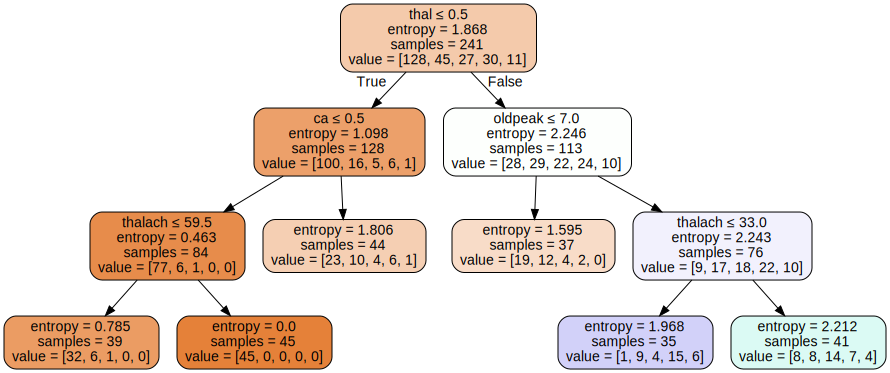

In [223]:
# Include decision tree visualization here
clf = tree.DecisionTreeClassifier(criterion="entropy", splitter="best", min_weight_fraction_leaf=.1)
clf = clf.fit(X_train, y_train)
# tree.plot_tree(clf)

import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal'],
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 
# Discuss what the model has learned


##Discussion:
the model has learned that when 'thal' is less than or equal to 0.5 and ca is greater 0.5 that the classification of patients is 23,10,4,6, or 1. To be honest though, I'm not totally sure what the metadata of this heart disease dataset actually means in terms of the classes. To inspect the metadata and data, go to this link: https://archive.ics.uci.edu/ml/datasets/Heart+Disease

## 6. (optional 5% extra credit) Implement reduced error pruning to help avoid overfitting.  
- You will need to take a validation set out of your training data to do this, while still having a test set to test your final accuracy. 
- Create a table comparing your decision tree implementation's results on the cars and voting data sets with and without reduced error pruning. 
- This table should compare:
    - a) The # of nodes (including leaf nodes) and tree depth of the final decision trees 
    - b) The generalization (test set) accuracy. (For the unpruned 10-fold CV models, just use their average values in the table).